# Predict Future Sales

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
import random
from dateutil.relativedelta import relativedelta
import os

In [2]:
from my_functions import exploiting_words, cleaning_shop_categs, convert_bronze, merge_basic, indexing_shop_categs , scaler, inversed_scale 
from my_functions import consolidation_prediction, plot_prediction
from my_functions import preparing_to_predict, plot_metrics

In [3]:
from especial_functions import balance_items_test, get_full_lags, feature_silver, integration_new_features_map
from especial_functions import features_rows_train_silver, exploiting_words, get_maps_from, balance_items_test
from especial_functions import augmentation_reduction

In [4]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [5]:
#from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn import preprocessing

### Data

In [6]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

<b> Treating the map item, category and shop

In [7]:
items_feature =  exploiting_words(data = items)

In [8]:
shops_feature, categories_feature = cleaning_shop_categs(shops, categories)
shops_feature = indexing_shop_categs(shops_feature, 'shop_comp1')
shops_feature = indexing_shop_categs(shops_feature, 'shop_comp2')
categories_feature = indexing_shop_categs(categories_feature, 'categ_comp1')
categories_feature = indexing_shop_categs(categories_feature, 'categ_comp2')

<b> Fast Cleaning

In [9]:
median = daily_train[(daily_train.shop_id == 32) & (daily_train.item_id == 2973) & (daily_train.date_block_num == 4) & (daily_train.item_price > 0)].item_price.median()
daily_train.loc[daily_train.item_price < 0, 'item_price'] = median

In [10]:
daily_train.loc[daily_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
daily_train.loc[daily_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
daily_train.loc[daily_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [11]:
### test preparation
test_data = test.copy()
test_data['date'] = pd.to_datetime(datetime.datetime(2015, 11, 1))
test_data['date_block_num'] = 35
test_data['item_price'] =  np.nan
test_data['item_cnt_day'] = np.nan
test_data = test_data[daily_train.columns]

In [12]:
test_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2015-11-01,35,5,5037,NaN,NaN
1,2015-11-01,35,5,5320,NaN,NaN
2,2015-11-01,35,5,5233,NaN,NaN
3,2015-11-01,35,5,5232,NaN,NaN
4,2015-11-01,35,5,5268,NaN,NaN


In [13]:
daily_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


<b> preparing Train aggregation

In [14]:
daily_train.shape

(2935849, 6)

In [15]:
train_bronze = convert_bronze(data = daily_train, train = True)

In [16]:
train_bronze.shape

(9784152, 6)

In [17]:
train_merge = merge_basic(train_data = train_bronze, items = items, items_feature = items_feature['item_name_explo'],
                            categories = categories_feature, shops = shops_feature)

In [18]:
train_merge.shape

(9784152, 22)

<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

In [22]:
train_bronze.Date.max()

Timestamp('2015-10-01 00:00:00')

In [23]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

#### hold-out Train

 almost 95% of the items available

In [24]:
len(daily_train.item_id.unique()), len(test.item_id.unique()), len(test.merge(daily_train, on = 'item_id', how = 'inner').item_id.unique())

(21807, 5100, 4737)

In [25]:
len(items)

22170

In [26]:
date_val = datetime.datetime(2014, 10, 1)

In [27]:
train_full = train_merge[train_merge.Date < date_val ].copy()
val_window = train_merge[train_merge.Date == date_val ].copy()

In [28]:
train_full.head()

,item_id,shop_id,Date,Sale,item_price,Order,item_name,item_category_id,lenstr,NWords,...,item_category_name,categ_comp1,categ_comp2,map_categ_comp1,map_categ_comp2,shop_name,shop_comp1,shop_comp2,map_shop_comp1,map_shop_comp2
0,19,25,2013-01-01,1.0,28.0,1,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,25,3,...,Кино - DVD,Кино,DVD,11,22,"Москва ТРК ""Атриум""",Москва,Атриум,14,18
1,27,2,2013-01-01,1.0,2499.0,1,"007 Legends [PS3, русская версия]",19,33,5,...,Игры - PS3,Игры,PS3,5,2,"Адыгея ТЦ ""Мега""",Адыгея,Мега,1,2
2,27,11,2013-01-01,1.0,1890.0,1,"007 Legends [PS3, русская версия]",19,33,5,...,Игры - PS3,Игры,PS3,5,2,Жуковский ул. Чкалова 39м²,Жуковский,None,7,0
3,27,19,2013-01-01,1.0,2499.0,1,"007 Legends [PS3, русская версия]",19,33,5,...,Игры - PS3,Игры,PS3,5,2,"Курск ТЦ ""Пушкинский""",Курск,Пушкинский,13,14
4,27,26,2013-01-01,1.0,2499.0,1,"007 Legends [PS3, русская версия]",19,33,5,...,Игры - PS3,Игры,PS3,5,2,"Москва ТЦ ""Ареал"" (Беляево)",Москва,Ареал,14,19


In [29]:
train_full.Date.max(), train_full.Date.min()

(Timestamp('2014-09-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [30]:
train_full.shape, val_window.shape

((4795917, 22), (339005, 22))

### Feature Exploration

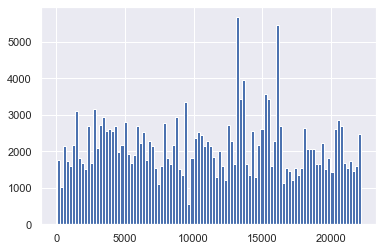

In [28]:
test_data.item_id.hist(bins = 100)

In [29]:
train_full.head()

,item_id,shop_id,Date,Sale,item_price,Order,item_name,item_category_id,lenstr,NWords,...,item_category_name,categ_comp1,categ_comp2,map_categ_comp1,map_categ_comp2,shop_name,shop_comp1,shop_comp2,map_shop_comp1,map_shop_comp2
0,19,25,2013-01-01,1.0,28.0,1,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,25,3,...,Кино - DVD,Кино,DVD,11,22,"Москва ТРК ""Атриум""",Москва,Атриум,14,18
1,27,2,2013-01-01,1.0,2499.0,1,"007 Legends [PS3, русская версия]",19,33,5,...,Игры - PS3,Игры,PS3,5,2,"Адыгея ТЦ ""Мега""",Адыгея,Мега,1,2
2,27,11,2013-01-01,1.0,1890.0,1,"007 Legends [PS3, русская версия]",19,33,5,...,Игры - PS3,Игры,PS3,5,2,Жуковский ул. Чкалова 39м²,Жуковский,None,7,0
3,27,19,2013-01-01,1.0,2499.0,1,"007 Legends [PS3, русская версия]",19,33,5,...,Игры - PS3,Игры,PS3,5,2,"Курск ТЦ ""Пушкинский""",Курск,Пушкинский,13,14
4,27,26,2013-01-01,1.0,2499.0,1,"007 Legends [PS3, русская версия]",19,33,5,...,Игры - PS3,Игры,PS3,5,2,"Москва ТЦ ""Ареал"" (Беляево)",Москва,Ареал,14,19


In [30]:
### Look for an alternative
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.50)

def q3(x):
    return x.quantile(0.90)

In [59]:
def binning_price(data, column, cut_bins  ): 
    var = data[column]
    data['binColumn'] =  pd.cut(var, bins = cut_bins, labels = cut_bins[0:-1], right = False)
    return data

In [123]:
def plot_1d_timeseries_var(data, variable, cut_bins = [] ):
    
    if cut_bins:
        data = binning_price(data, 'item_price', cut_bins)
        variable = 'binColumn'
    
    summary = data.groupby([variable, 'Date']).agg(
        Min = ('Sale','min'),
        Mean= ('Sale','mean'),
        Q3 = ('Sale', lambda x: np.percentile(x, 95) ),
        Max = ('Sale','max'),
        ).reset_index()

    summary = summary.melt( id_vars=[variable,'Date'], value_vars=['Min','Mean','Q3','Max'], var_name='Metric', value_name='Value').reset_index()

    objects = list(summary[variable].unique())
    random.shuffle(objects)

    fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20,20), sharex=True)
    ax = sns.lineplot(ax = axs[0] , data = summary[summary[variable] ==objects[0]], x="Date", y="Value", hue = 'Metric' )
    ax = sns.lineplot(ax = axs[1] , data = summary[summary[variable] ==objects[1]], x="Date", y="Value", hue = 'Metric' )
    ax = sns.lineplot(ax = axs[2] , data = summary[summary[variable] == objects[2]], x="Date", y="Value", hue = 'Metric' )
    ax = sns.lineplot(ax = axs[3] , data = summary[summary[variable] == objects[3]], x="Date", y="Value", hue = 'Metric' )
    
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(20,4), sharex=True)
    ax = sns.histplot(ax = axs[0] , data = summary[summary.Metric == 'Min'], x="Value", hue = 'Metric' , bins = 35 )
    ax = sns.histplot(ax = axs[1] , data = summary[summary.Metric == 'Mean'], x="Value", hue = 'Metric', bins = 35 )
    ax = sns.histplot(ax = axs[2] , data = summary[summary.Metric == 'Q3'], x="Value", hue = 'Metric', bins = 35 )
    ax = sns.histplot(ax = axs[3] , data = summary[summary.Metric == 'Max'], x="Value", hue = 'Metric' , bins = 35 )

In [125]:
train_full.columns

Index(['item_id', 'shop_id', 'Date', 'Sale', 'item_price', 'Order',
       'item_name', 'item_category_id', 'lenstr', 'NWords', 'Word0', 'Word_1',
       'item_category_name', 'categ_comp1', 'categ_comp2', 'map_categ_comp1',
       'map_categ_comp2', 'shop_name', 'shop_comp1', 'shop_comp2',
       'map_shop_comp1', 'map_shop_comp2', 'binPrice', 'binColumn'],
      dtype='object')

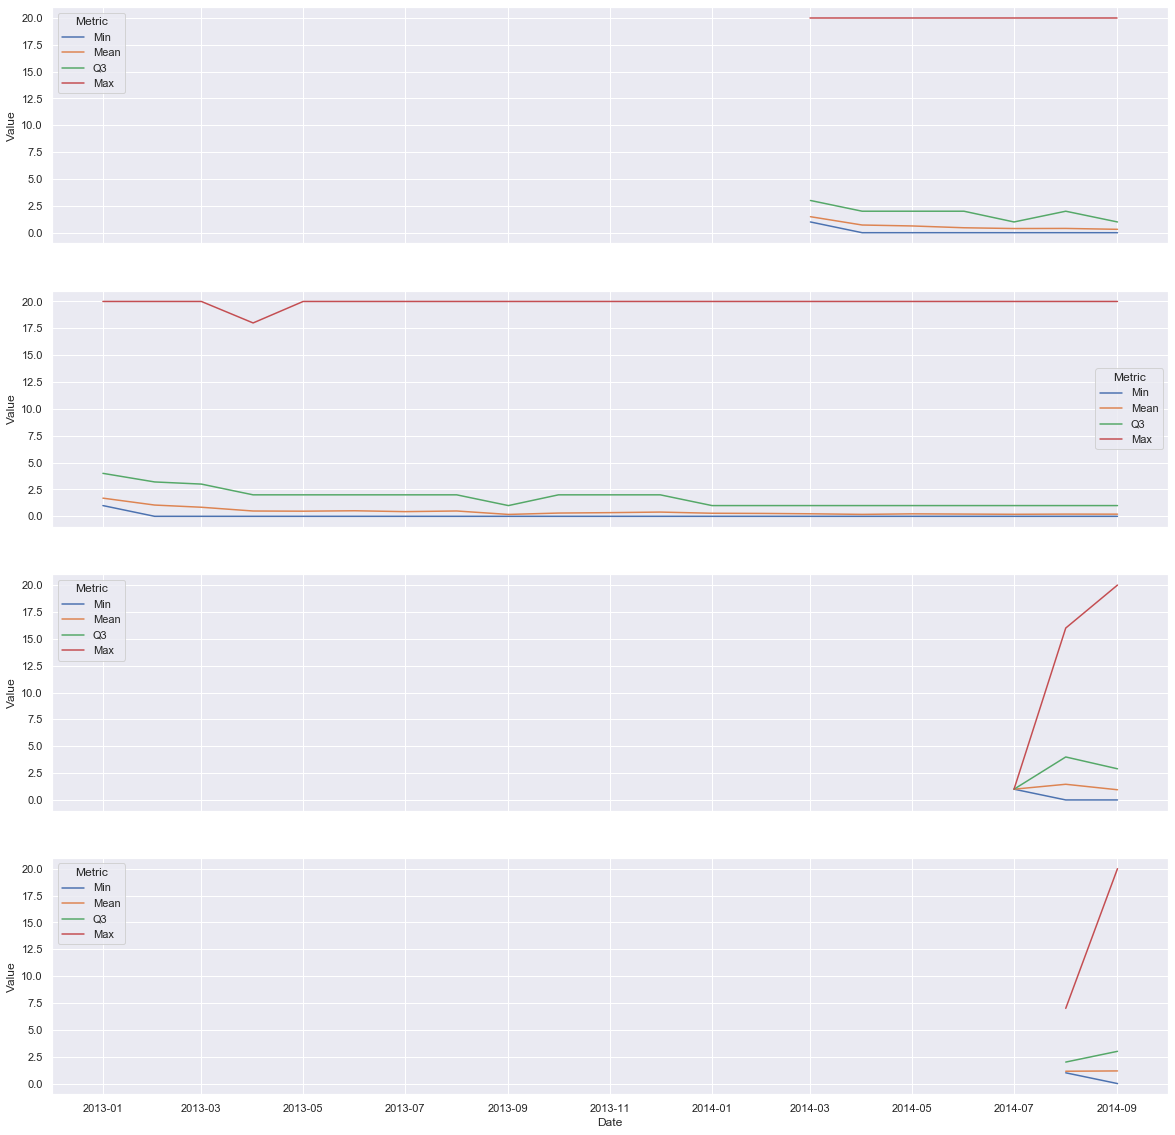

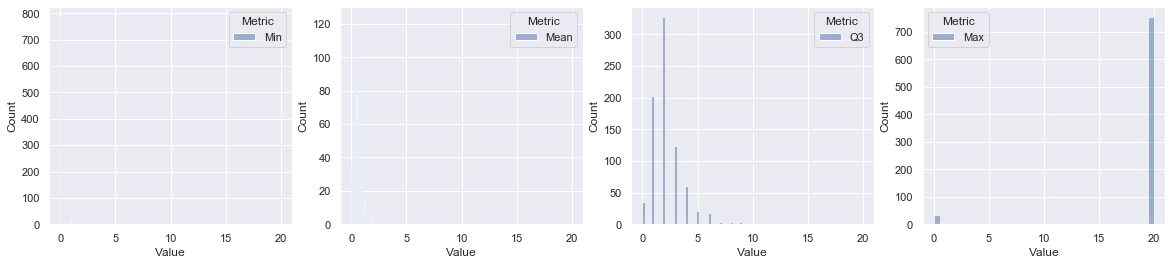

In [142]:
#bins = [0,10,20,30,40,50,60,100,200,300,400,500,1000,2000,3000,4000,5000,6000,10000,20000,30000,50000,100000,200000,300000,1000000]
plot_1d_timeseries_var(train_full, 'map_shop_comp2')

* item_id with mean or even 95q qnd even max
* shop_id with Q3
* item_price using bins and with mean and q3
* item_category_id with mean and q3 
* lenstr with mean or q3
* NWords with mean or q3
* Word0 with mean or q3**
* Word_1 with mean or q3**
* map_categ_comp1 with mean or q3**
* map_categ_comp2  with mean or q3**
* map_shop_comp1 with mean or q3**
* map_shop_comp1 with q3**

#### Further shop_id variables

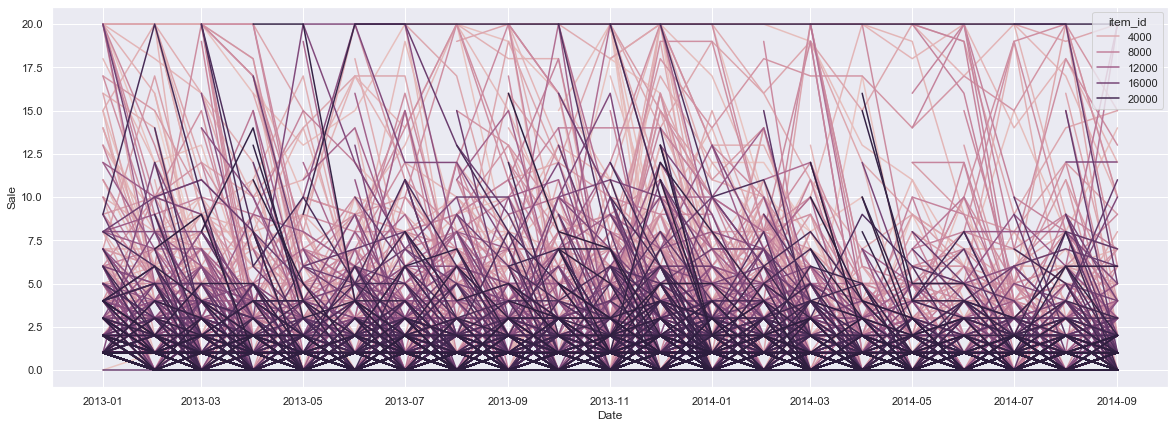

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7), sharex=True)
ax = sns.lineplot(ax = axs , data = train_full[train_full['shop_id'] == 15], x="Date", y="Sale", hue = 'item_id' )

In [31]:
train_full.columns

Index(['item_id', 'shop_id', 'Date', 'Sale', 'item_price', 'Order',
       'item_name', 'item_category_id', 'lenstr', 'NWords', 'Word0', 'Word_1',
       'item_category_name', 'categ_comp1', 'categ_comp2', 'map_categ_comp1',
       'map_categ_comp2', 'shop_name', 'shop_comp1', 'shop_comp2',
       'map_shop_comp1', 'map_shop_comp2'],
      dtype='object')

In [37]:
summary = train_full.copy()

In [60]:
def plot_shop_explorer(data, variable, cut_bins = []):
    
    if cut_bins:
        data = binning_price(data, 'item_price', cut_bins)
        variable = 'binColumn'
    
    dfplot = data.groupby(['Date','shop_id']).agg(countUniqVar = (variable, 'nunique'),
                                       meanSale = ('Sale','mean')).reset_index()
    
    sns.histplot(
    dfplot, x="countUniqVar", y="meanSale",
    bins=30, discrete=(False, False), log_scale=(False, False),
    pthresh=.05, pmax=.9,
    )

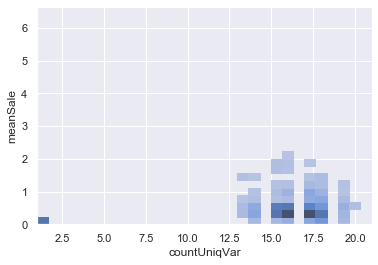

In [61]:
bins = [0,10,20,30,40,50,60,100,200,300,400,500,1000,2000,3000,4000,5000,6000,10000,20000,30000,50000,100000,200000,300000,1000000]

plot_shop_explorer(data = summary, variable = 'item_price', cut_bins = bins)

* somewhat usefull to use the count unique of item_id by shop_id
* somewhat usefull to use the count unique of map_categ_comp1 by shop_id